Install requirements

In [5]:
!pip install deeplake
!pip install deeplake[audio]
!pip install PyAV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56

Import libraries

In [6]:
import deeplake
import librosa

Load the dataset and print the summary

In [7]:
ds = deeplake.load("hub://activeloop/nsynth-train")
ds.summary()

-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nsynth-train



\

hub://activeloop/nsynth-train loaded successfully.

Dataset(path='hub://activeloop/nsynth-train', read_only=True, tensors=['audios', 'instrument', 'instrument_family', 'instrument_source', 'note', 'pitch', 'qualities', 'sample_rate', 'velocity'])

      tensor           htype           shape          dtype  compression
      -------         -------         -------        -------  ------- 
      audios           audio     (289205, 64000, 1)   None      wav   
    instrument        generic       (289205, 1)      uint32    None   
 instrument_family  class_label     (289205, 1)      uint32    None   
 instrument_source  class_label     (289205, 1)      uint32    None   
       note            text         (289205, 1)        str     None   
       pitch          generic       (289205, 1)      uint32    None   
     qualities      class_label    (289205, 0:5)     uint32    None   
    sample_rate       generic       (289205, 1)      uint32    None   
     velocity         generic       (289

Get audio details

In [8]:
audio_tensor = ds['audios']

print("tensor:        ", "audios")
print("htype:         ", audio_tensor.htype)
print("shape:         ", audio_tensor.shape)
print("dtype:         ", audio_tensor.dtype)

tensor:         audios
htype:          audio
shape:          (289205, 64000, 1)
dtype:          float64


Listen to the audio

In [9]:
import numpy as np
from IPython.display import Audio

# Extract the nth audio sample
n = 0  # This will be the first audio sample
audio_sample = ds['audios'][n].numpy().squeeze()  # Convert to numpy array and remove unnecessary dimension

# 16kHz rate
sample_rate = 16000

# Use IPython's Audio utility to play the audio
Audio(audio_sample, rate=sample_rate)

Only grab the dataset where instument == keyboard

In [10]:
filtered_ds_audio = []
filtered_ds_pitch = []
pitch_values = ds['pitch'].numpy().squeeze()

#for i, sample in enumerate(ds[:200]):
for i in range(len(ds)):
  instrument_family = ds[i].instrument_family.data()['text'][0]
  if instrument_family == 'keyboard':
    audio_sample = ds['audios'][i].numpy().squeeze()  # Convert to numpy array and remove unnecessary dimension

    # Trim the audio
    audio_sample = audio_sample[:int(3 * 16000)]
    # Convert audio to CQT (Constant-Q Transform)
    audio_sample = librosa.cqt(audio_sample, sr=16000)

    filtered_ds_audio.append(audio_sample)
    # Add modified pitch value to the list
    filtered_ds_pitch.append(pitch_values[i]-21)

#print("audio array: ", filtered_ds_audio, " \n")
print(len(filtered_ds_audio))
#print("pitch: ",filtered_ds_pitch, " \n")
print(len(filtered_ds_pitch))

/usr/local/lib/python3.10/dist-packages/deeplake/core/dataset/dataset.py:574: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


KeyboardInterrupt: ignored

In [12]:
# =================== Augmentation Function Library ==================
def noise_injection(audio, noise_factor = 0.001):
  '''Inject random/white noise into the audio'''
  noise = np.random.randn(len(audio))
  return audio + noise_factor * noise

def change_speed(audio, speed_factor = 2):
  '''
  Changes the speed of playback by scaling time
  speed_factor > 1      => speeds up playback
  0 < speed_factor < 1  => slows down playback
  '''
  return librosa.effects.time_stretch(audio, rate=speed_factor)

def change_speed_and_fit(audio, stretch_factor = 0.5):
  '''Changes speed similar to change_speed and fits into the same length as the input audio'''
  input_length = len(audio)
  stretched_audio = librosa.effects.time_stretch(audio.astype('float'), rate=stretch_factor)
  if len(stretched_audio) > input_length:
    return stretched_audio[:input_length]
  else:
    return np.pad(stretched_audio, (0, max(0, input_length - len(stretched_audio))), "constant")

def shift_pitch(audio, steps = 10, sr=16000):
  '''Shifts the pitch up by the specified amount of steps'''
  return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)

def shift_time(audio, shift_factor = 0.5, random = False):
  '''Shifts the audio in time by a given factor, keeping the same length of the intial audio'''
  if random:
    shift_factor = shift_factor * 2 * (np.random.uniform() - 0.5)

  start = int(len(audio) * shift_factor)
  if (start > 0):
      return np.pad(audio,(start,0),mode='constant')[0:len(audio)]
  else:
      return np.pad(audio,(0,-start),mode='constant')[0:len(audio)]

Original audio


Augmented audio


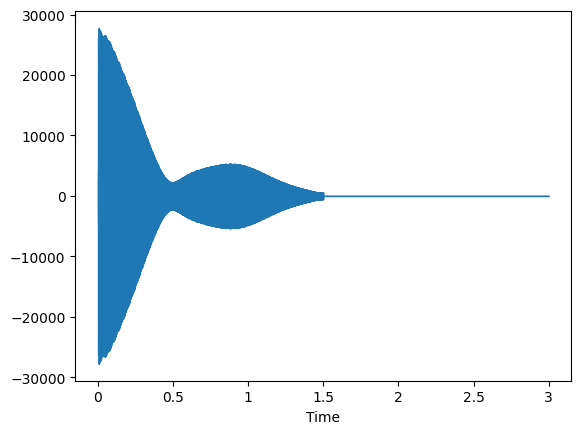

In [13]:
# ------------ Original audio ------------
# wavPath = "/content/PinkPanther30.wav"
# wavPath = "/content/piano2.wav"
# audio, sample_rate = librosa.load(wavPath)
audio = audio_sample

print("Original audio")
display(Audio(audio, rate=sample_rate))

# ------------ Noise Injection ------------
# audio = noise_injection(audio)

# ----------- Changing speed ------------
# audio = change_speed(audio)
# audio = change_speed(audio, speed_factor=0.5)
# audio = change_speed_and_fit(audio, stretch_factor=0.5)
audio = change_speed_and_fit(audio, stretch_factor=2)

# ------------ Pitch Shift --------------
# audio = shift_pitch(audio)

# ------------ Time Shift --------------
# audio = shift_time(audio)

print("Augmented audio")
librosa.display.waveshow(audio.astype('float'), sr=sample_rate)
display(Audio(audio, rate=sample_rate))

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np

# General Purpose Data Loader
def get_data_loader(ds, batch_size=64):
  filtered_audio = []
  filtered_pitch = []
  pitch_values = ds['pitch'].numpy().squeeze()

  for i, data in enumerate(ds):
    instrument_family = ds[i].instrument_family.data()['text'][0]

    # When instrument is piano
    if instrument_family == 'keyboard':
      # Convert to numpy array and remove unnecessary dimension
      audio_sample = ds['audios'][i].numpy().squeeze()

      # Trim the audio
      audio_sample = audio_sample[:int(3 * 16000)]

      # ============= Pick from Augmentation Library ===================
      # Pass audio through augmentations if needed

      # Convert audio to CQT (Constant-Q Transform)
      audio_sample = librosa.cqt(audio_sample, sr=16000)

      # Add audio to dataset
      filtered_audio.append(audio_sample)

      # Add modified pitch value to the pitch list
      filtered_pitch.append(pitch_values[i]-21)

  sampler = SubsetRandomSampler(range(len(filtered_audio)))
  loader = torch.utils.data.DataLoader(filtered_audio,
      batch_size=batch_size, num_workers=1, sampler=sampler)

  return loader

# Download data
trainds = deeplake.load("hub://activeloop/nsynth-train")
valds = deeplake.load("hub://activeloop/nsynth-val")
testds = deeplake.load("hub://activeloop/nsynth-test")

# Input to model
# batch_size = 64 # Change if necessary
train_loader = get_data_loader(trainds)
val_loader = get_data_loader(valds)
test_loader = get_data_loader(testds)
classes = list(range(88))

for i, data in train_loader:
  print(data)
  break;

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nsynth-train



/

hub://activeloop/nsynth-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nsynth-val



|

hub://activeloop/nsynth-val loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nsynth-test



\

hub://activeloop/nsynth-test loaded successfully.



/usr/local/lib/python3.10/dist-packages/deeplake/core/dataset/dataset.py:574: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Next step is to speed up the loading process:

1.   Use torch loading to speed up the process
2.   Save the loaded data in a file for later access



In [ ]:
torch.save(train_loader, 'trainloader.csv')
torch.save(val_loader, 'valloader.csv')
torch.save(test_loader, 'trainloader.csv')